In [449]:

import os 
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import yaml
import json
from pprint import pprint
from glob import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import pyrender

import pygarment as pyg
import open3d as o3d
import trimesh
import plotly.graph_objects as go
import PIL
from PIL import Image

from analysis_utils import visualize_meshes_plotly, v_id_map, plot_panel_info

PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(PROJECT_ROOT_PATH, "neutral_body/mean_all.obj")
    
default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

print("body vertices", default_body_mesh.vertices.shape)
print("body faces", default_body_mesh.faces.shape)

body vertices (23751, 3)
body faces (47500, 3)


### Rendering Functions and Settings

In [451]:
# basic render utility functions

import os
import platform
if platform.system() == 'Linux':
    os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ['MESA_GL_VERSION_OVERRIDE'] = '4.1' 
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '410'

def rotate_matrix_y(matrix, angle_deg):
    rotation_angle = angle_deg * (np.pi / 180)

    # Define the rotation matrix for 180-degree rotation around the y-axis
    rotation_matrix = np.array([
        [np.cos(rotation_angle), 0, np.sin(rotation_angle), 0],
        [0, 1, 0, 0],
        [-np.sin(rotation_angle), 0, np.cos(rotation_angle), 0],
        [0, 0, 0, 1]
    ])

    # Apply the rotation to the mesh vertices
    rot_matrix = np.dot(rotation_matrix, matrix)
    return rot_matrix

def rotate_matrix_x(matrix, angle_deg):
    rotation_angle = angle_deg * (np.pi / 180)

    # Define the rotation matrix for 180-degree rotation around the y-axis
    rotation_matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(rotation_angle), -np.sin(rotation_angle), 0],
        [0, np.sin(rotation_angle), np.cos(rotation_angle), 0],
        [0, 0, 0, 1]
    ])

    # Apply the rotation to the mesh vertices
    rot_matrix = np.dot(rotation_matrix, matrix)
    return rot_matrix

def create_lights(scene, intensity=30.0):
    light_positions = [
        np.array([1.60614, 1.5341, 1.23701]),
        np.array([1.31844, 1.92831, -2.52238]),
        np.array([-2.80522, 1.2594, 2.34624]),
        np.array([0.160261, 1.81789, 3.52215]),
        np.array([-2.65752, 1.41194, -1.26328])
    ]
    light_colors = [
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0]
    ]

    # Add lights to the scene
    for i in range(5):
        light = pyrender.PointLight(color=light_colors[i], intensity=intensity)
        light_pose = np.eye(4)
        light_pose[:3, 3] = light_positions[i]
        scene.add(light, pose=light_pose)



def create_camera(pyrender, pyrender_body_mesh, scene, side, camera_location=None):

    # Create a camera
    y_fov = np.pi / 6. 
    camera = pyrender.PerspectiveCamera(yfov=y_fov)
    

    if camera_location is None:
        # Evaluate w.r.t. body

        fov = 50  # Set your desired field of view in degrees 

        # # Calculate the bounding box center of the mesh
        bounding_box_center = pyrender_body_mesh.bounds.mean(axis=0)

        # Calculate the diagonal length of the bounding box
        diagonal_length = np.linalg.norm(pyrender_body_mesh.bounds[1] - pyrender_body_mesh.bounds[0])

        # Calculate the distance of the camera from the object based on the diagonal length
        distance = 1.5 * diagonal_length / (2 * np.tan(np.radians(fov / 2)))

        camera_location = bounding_box_center
        camera_location[-1] += distance

    # Calculate the camera pose
    camera_pose = np.array([
        [1.0, 0.0, 0.0, camera_location[0]],
        [0.0, 1.0, 0.0, camera_location[1]],
        [0.0, 0.0, 1.0, camera_location[2]],
        [0.0, 0.0, 0.0, 1.0]
    ])

    camera_pose = rotate_matrix_x(camera_pose, -15)
    camera_pose = rotate_matrix_y(camera_pose, 20)
    if side == 'back':
        camera_pose = rotate_matrix_y(camera_pose, 180)
    elif side == 'right':
        camera_pose = rotate_matrix_y(camera_pose, -90)
    elif side == 'left':
        camera_pose = rotate_matrix_y(camera_pose, 90)

    # Set camera's pose in the scene
    scene.add(camera, pose=camera_pose)
    
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "back", "right", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}


## Visualize Default Body Setting

## Note

garment_5000_27/random_body/dataset_properties_random_body.yaml 도 고려해야 함

In [452]:
IDX = 1000
# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

garment_path = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))[IDX]

# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0BD28UCVO8"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_3/default_body/rand_005ZYVMOCL"
garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0A36YXPNV0"
garment_id = os.path.basename(garment_path)

SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

print(stitch_dict)

{0: [{'panel': 'sl_right_cuff_skirt_f', 'edge': 3}, {'panel': 'sl_right_cuff_skirt_b', 'edge': 0}], 1: [{'panel': 'sl_right_cuff_skirt_f', 'edge': 1}, {'panel': 'sl_right_cuff_skirt_b', 'edge': 2}], 2: [{'panel': 'right_sleeve_f', 'edge': 3}, {'panel': 'right_sleeve_b', 'edge': 1}], 3: [{'panel': 'right_sleeve_f', 'edge': 4}, {'panel': 'right_sleeve_b', 'edge': 0}], 4: [{'panel': 'right_sleeve_f', 'edge': 1}, {'panel': 'right_sleeve_b', 'edge': 4}], 5: [{'panel': 'sl_right_cuff_skirt_f', 'edge': 2}, {'panel': 'right_sleeve_f', 'edge': 0}], 6: [{'panel': 'sl_right_cuff_skirt_b', 'edge': 1}, {'panel': 'right_sleeve_b', 'edge': 5}], 7: [{'panel': 'right_sleeve_f', 'edge': 2}, {'panel': 'right_ftorso', 'edge': 5}], 8: [{'panel': 'right_sleeve_b', 'edge': 2}, {'panel': 'right_ftorso', 'edge': 4}], 9: [{'panel': 'right_sleeve_b', 'edge': 3}, {'panel': 'right_btorso', 'edge': 4}], 10: [{'panel': 'right_ftorso', 'edge': 3}, {'panel': 'right_btorso', 'edge': 5}], 11: [{'panel': 'right_ftorso', 

In [453]:
# with open(os.path.join(
#     "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_3/default_body/rand_005ZYVMOCL",
#     "rand_005ZYVMOCL_specification.json"
# ), "r") as f:
#     spec = json.load(f)
    
# pprint(spec["pattern"]["stitches"])

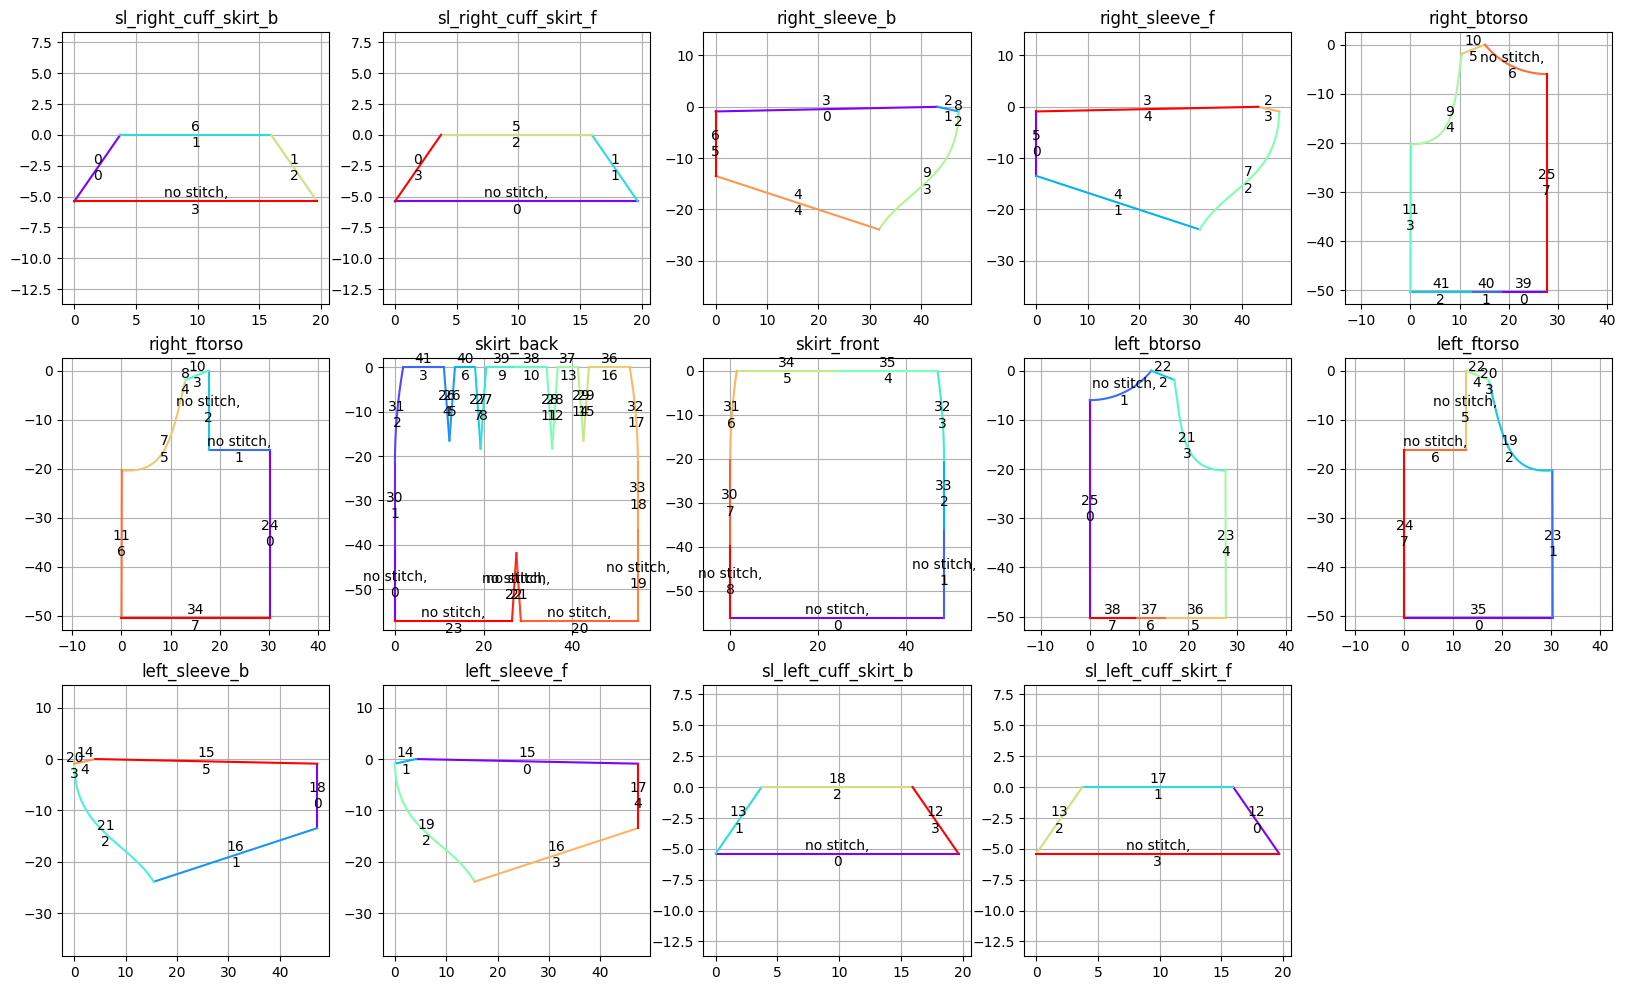

In [454]:
FIGLEN = 4
NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))
NCOLS = 5
NROWS = 3

plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    ax.set_title(panel_name)
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
# plt.savefig(f"{garment_id}_panel_vis.png")
plt.show()

In [455]:
def get_vertex_neighbors(faces, vertex_mask):
    """Get 1-hop neighbor vertices of masked vertices"""
    neighbor_mask = np.zeros(len(vertex_mask), dtype=bool)
    
    face_mask = np.any(vertex_mask[faces], axis=1)
    relevant_faces = faces[face_mask]
    
    neighbor_mask[relevant_faces.flatten()] = True
    
    return neighbor_mask

simulated_garment_mesh = trimesh.load_mesh(
    os.path.join(garment_path, f"{garment_id}_sim.ply"),
    process=False
)
simulated_garment_mesh.vertices = simulated_garment_mesh.vertices / 100

tex_image = PIL.Image.open(os.path.join(garment_path, f"{garment_id}_texture.png"))
texture = trimesh.visual.TextureVisuals(
    simulated_garment_mesh.visual.uv,
    image=tex_image
)
simulated_garment_mesh.visual = texture

print("vertices", simulated_garment_mesh.vertices.shape)
print("faces", simulated_garment_mesh.faces.shape)

idx_convert_map = v_id_map(simulated_garment_mesh.vertices)

print("idx_convert_map length", len(idx_convert_map))
print()

# Read Vertex Label
with open(os.path.join(garment_path, f"{garment_id}_sim_segmentation.txt"), "r") as f:
    segmentation = list(map(
        lambda x : x.strip(),
        f.readlines()
    ))

panel_vertex_mask_dict = {}
for k in panel_svg_path_dict.keys():
    raw_mask = list(map(
        lambda x : True if x.startswith(k) else False,
        segmentation
    ))
    panel_vertex_mask_dict[k] = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))

stitch_vertex_mask_dict = {}
stitch_vertex_extended_mask_dict = {}
for k in stitch_dict.keys():
    raw_mask = list(map(
        lambda x : True if f"stitch_{k}" in x.split(",") else False,
        segmentation
    ))
    base_mask = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))
    stitch_vertex_mask_dict[k] = base_mask
    stitch_vertex_extended_mask_dict[k] = get_vertex_neighbors(simulated_garment_mesh.faces, base_mask)
    
pprint(list(panel_vertex_mask_dict.keys()))
print(list(stitch_vertex_mask_dict.keys()))


vertices (18002, 3)
faces (34015, 3)
idx_convert_map length 18002

['sl_right_cuff_skirt_b',
 'sl_right_cuff_skirt_f',
 'right_sleeve_b',
 'right_sleeve_f',
 'right_btorso',
 'right_ftorso',
 'skirt_back',
 'skirt_front',
 'left_btorso',
 'left_ftorso',
 'left_sleeve_b',
 'left_sleeve_f',
 'sl_left_cuff_skirt_b',
 'sl_left_cuff_skirt_f']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [456]:
# # Make Filtered Mesh

# full_vertices = np.array(simulated_garment_mesh.vertices)
# full_edges = np.array(simulated_garment_mesh.edges)
# full_faces = np.array(simulated_garment_mesh.faces)

# filtered2full_idx_map = {}
# for idx, filtered_idx in enumerate(idx_convert_map):
#     if filtered_idx in filtered2full_idx_map :
#         filtered2full_idx_map[filtered_idx].append(idx)
#     else:
#         filtered2full_idx_map[filtered_idx] = [idx]
        
        
# filtered_idx_list = []
# filtered_vertices = []
# for full_idx, filtered_idx in enumerate(idx_convert_map):
#     if filtered_idx in filtered_idx_list:
#         continue
#     filtered_idx_list.append(filtered_idx)
#     filtered_vertices.append(full_vertices[full_idx])
# filtered_vertices = np.array(filtered_vertices)


# filtered_edges = []
# for orig_edge in full_edges:
#     stt = idx_convert_map[orig_edge[0]]
#     end = idx_convert_map[orig_edge[1]]
#     filtered_edges.append([stt, end])
# filtered_edges = np.array(filtered_edges)

# filtered_faces = []
# for idx, orig_face in enumerate(full_faces):
    
#     v1, v2, v3 = sorted([
#         idx_convert_map[orig_face[0]],
#         idx_convert_map[orig_face[1]],
#         idx_convert_map[orig_face[2]]
#     ])
#     filtered_faces.append([v1, v2, v3])
# filtered_faces = np.array(filtered_faces)


# filtered_mesh = trimesh.Trimesh(
#     vertices=filtered_vertices,
#     edges=filtered_edges,
#     faces=filtered_faces,
#     process=False
# )


# filtered_stitch_vertex_mask_dict = {}
# for stitch_idx in stitch_vertex_mask_dict.keys():
#     filtered_stitch_vertex_mask_dict[stitch_idx] = np.array(
#         [False] * len(filtered_vertices)
#     )
#     for orig_vert_idx, val in enumerate(stitch_vertex_mask_dict[stitch_idx]):
#         if val:
#             filtered_vert_idx = idx_convert_map[orig_vert_idx]
#             filtered_stitch_vertex_mask_dict[stitch_idx][filtered_vert_idx] = True


# # STITCH_IDX = 0
# # visualize_meshes_plotly(
# #     [filtered_mesh,],
# #     vertices_list=[
# #         filtered_mesh.vertices[filtered_stitch_vertex_mask_dict[STITCH_IDX]]
# #     ],
# #     vertices_color_list=["red"],
# #     vertex_marker_size=5
# # )


In [524]:
import random

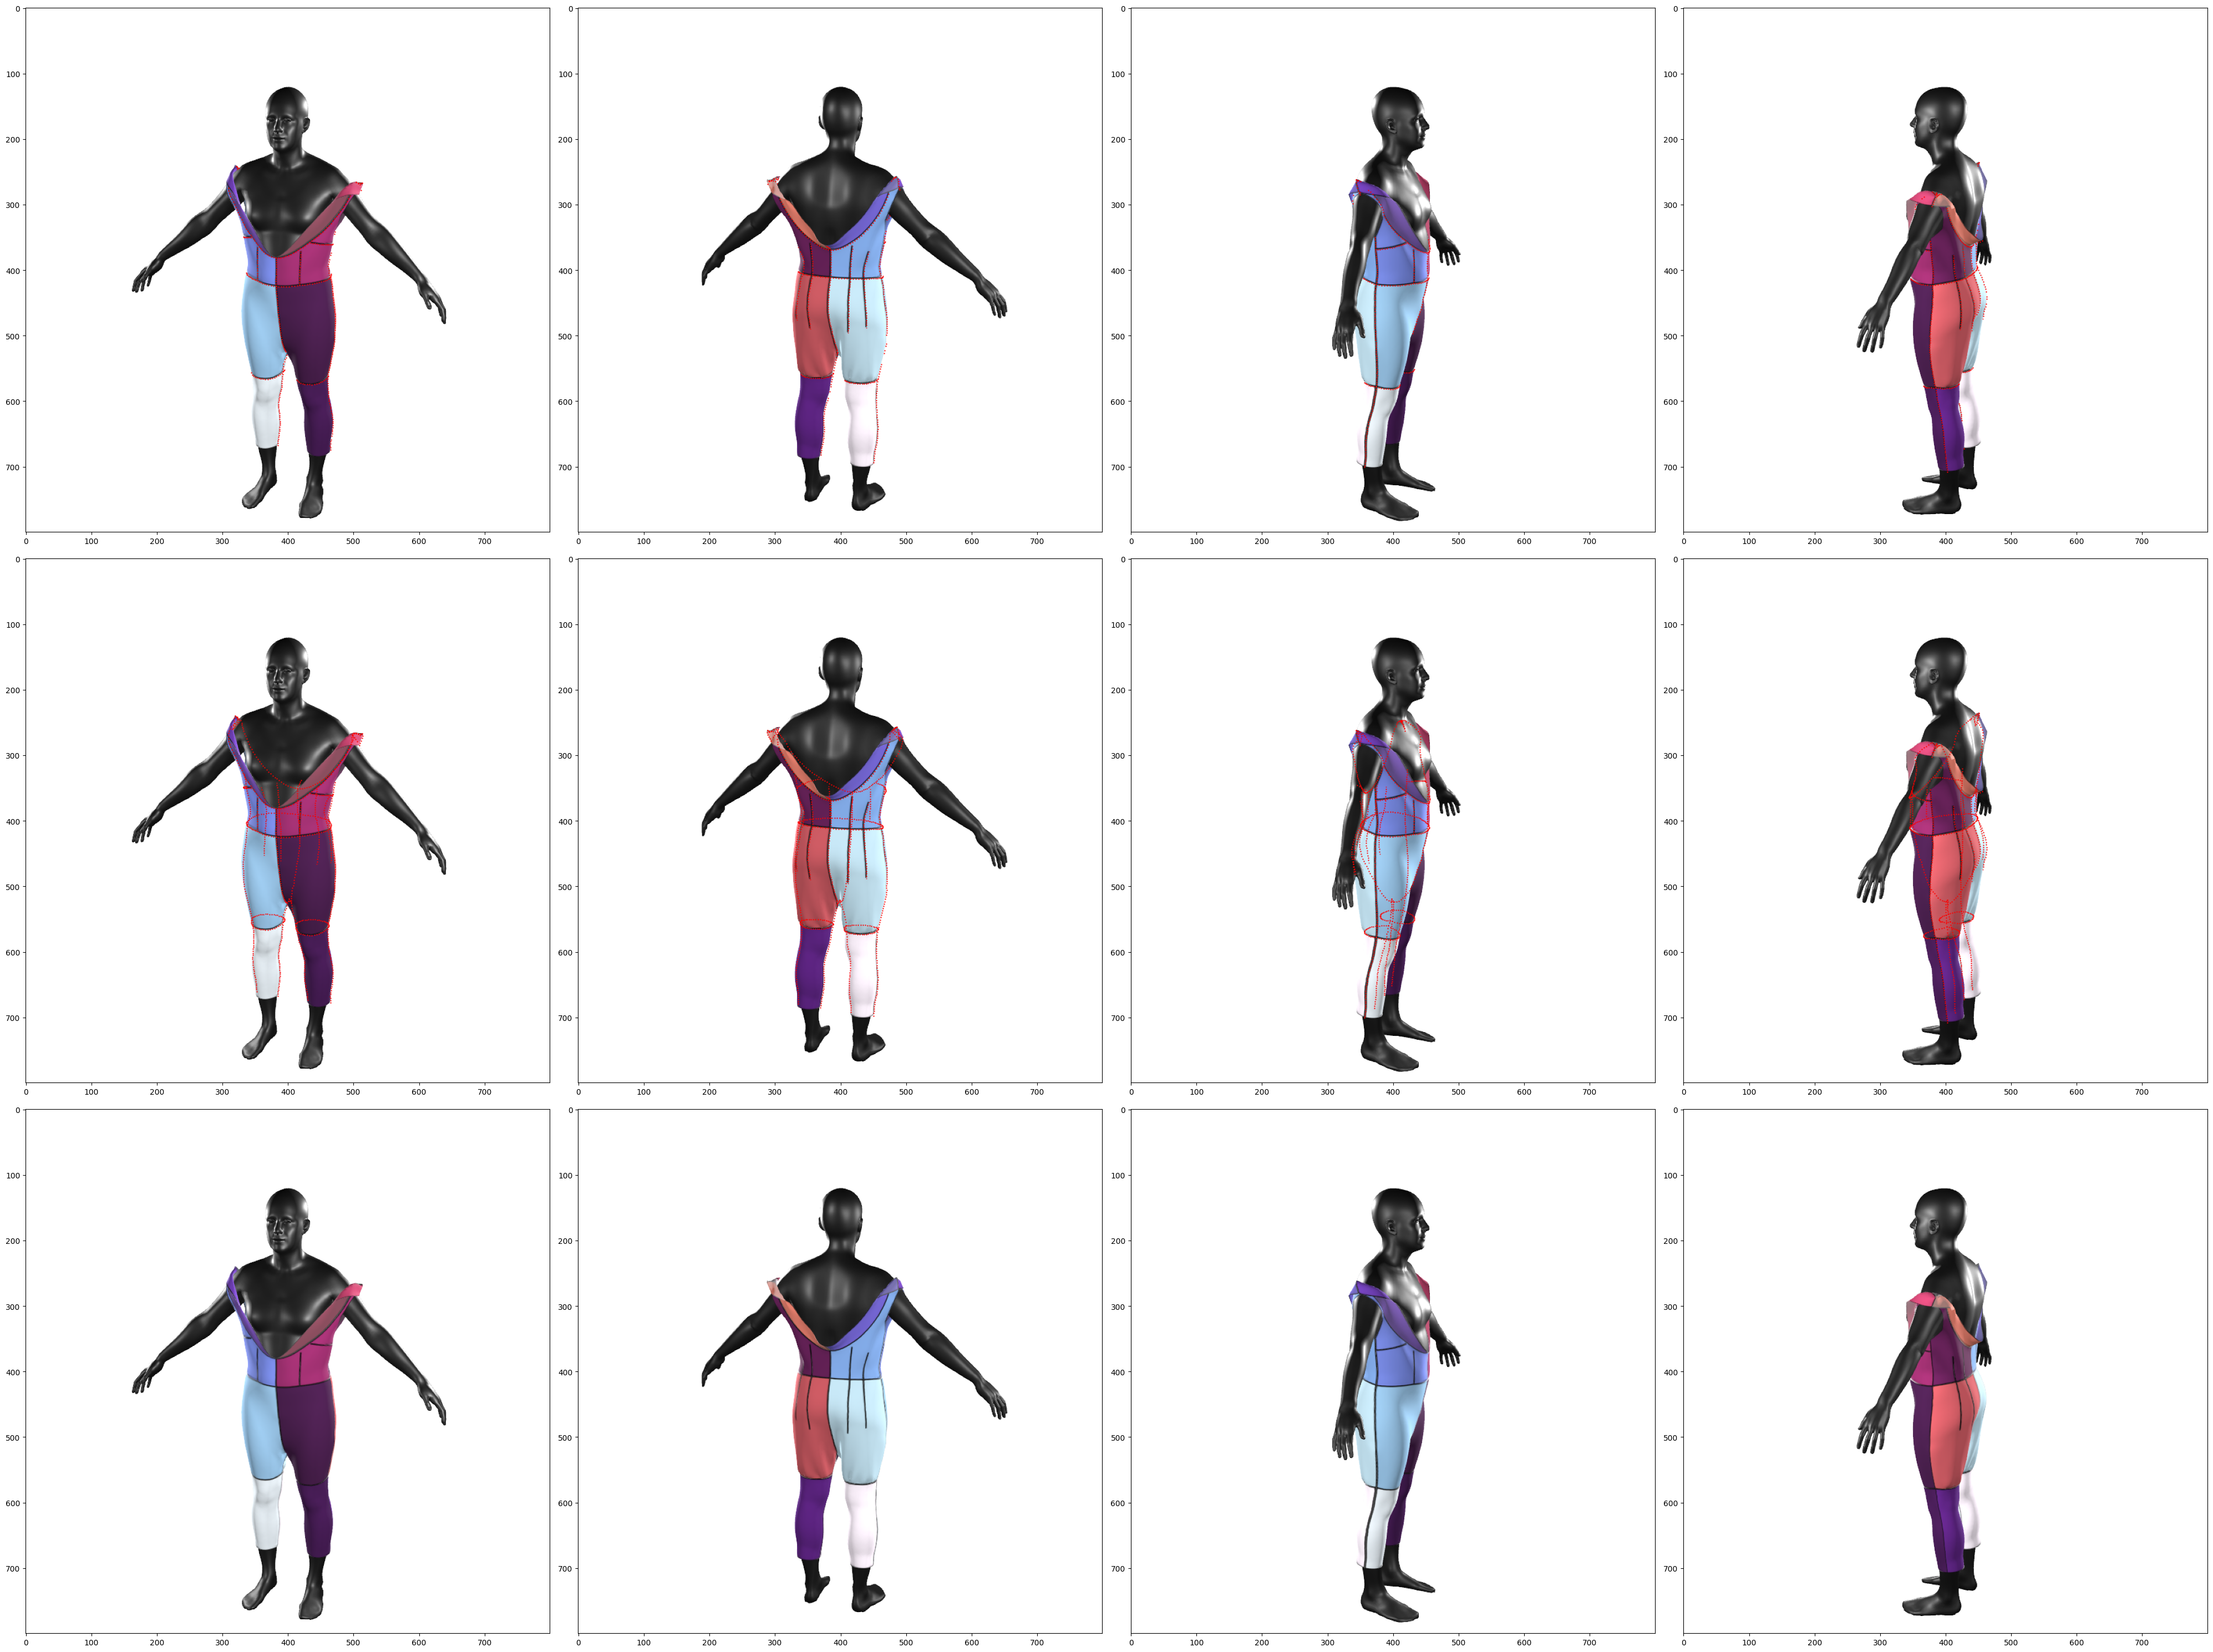

In [547]:


# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))


# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_3/default_body/rand_005ZYVMOCL"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0BD28UCVO8"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0A36YXPNV0"
# ================================
IDX = 1000

IDX = random.randint(0, len(garment_path_list) - 1)
# ================================

garment_path = garment_path_list[IDX]

garment_id = os.path.basename(garment_path)

SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}


simulated_garment_mesh = trimesh.load_mesh(
    os.path.join(garment_path, f"{garment_id}_sim.ply"),
    process=False
)
simulated_garment_mesh.vertices = simulated_garment_mesh.vertices / 100

tex_image = PIL.Image.open(os.path.join(garment_path, f"{garment_id}_texture.png"))
texture = trimesh.visual.TextureVisuals(
    simulated_garment_mesh.visual.uv,
    image=tex_image
)
simulated_garment_mesh.visual = texture

idx_convert_map = v_id_map(simulated_garment_mesh.vertices)

# Read Vertex Label
with open(os.path.join(garment_path, f"{garment_id}_sim_segmentation.txt"), "r") as f:
    segmentation = list(map(
        lambda x : x.strip(),
        f.readlines()
    ))

panel_vertex_mask_dict = {}
for k in panel_svg_path_dict.keys():
    raw_mask = list(map(
        lambda x : True if x.startswith(k) else False,
        segmentation
    ))
    panel_vertex_mask_dict[k] = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))

stitch_vertex_mask_dict = {}
for k in stitch_dict.keys():
    raw_mask = list(map(
        lambda x : True if f"stitch_{k}" in x.split(",") else False,
        segmentation
    ))
    base_mask = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))
    stitch_vertex_mask_dict[k] = base_mask

# ready pyrender meshes
body_material = pyrender.MetallicRoughnessMaterial(
    baseColorFactor=(0.0, 0.0, 0.0, 1.0),  # RGB color, Alpha
    metallicFactor=0.658,  # Range: [0.0, 1.0]
    roughnessFactor=0.5  # Range: [0.0, 1.0]
)
pyrender_body_mesh = pyrender.Mesh.from_trimesh(default_body_mesh, material=body_material)


material = simulated_garment_mesh.visual.material.to_pbr()
material.baseColorFactor = [1., 1., 1., 1.]
material.doubleSided = True  # color both face sides  

white_back = Image.new('RGBA', material.baseColorTexture.size, color=(255, 255, 255, 255))
white_back.paste(material.baseColorTexture)
material.baseColorTexture = white_back.convert('RGB')  

simulated_garment_mesh.visual.material = material

pyrender_garm_mesh = pyrender.Mesh.from_trimesh(
    simulated_garment_mesh, smooth=True
) 



rendered_image_dict = {}
depth_image_dict = {}
projected_vertex_pose_dict = {}
vertex_visibility_mask_dict = {}

for side in render_props["sides"]:
    scene = pyrender.Scene(bg_color=(1., 1., 1., 0.))
    
    scene.add(pyrender_garm_mesh)
    scene.add(pyrender_body_mesh)

    create_camera(
        pyrender,
        pyrender_body_mesh, scene, side,
        camera_location=render_props["front_camera_location"]
    )
    create_lights(scene, intensity=80.)
    
    camera_node = list(filter(
        lambda x : x.camera is not None,
        scene.get_nodes()
    ))[-1]
    
    renderer = pyrender.OffscreenRenderer(
        viewport_width=render_props["resolution"][0],
        viewport_height=render_props["resolution"][1]
    )
    
    flags = pyrender.RenderFlags.RGBA | pyrender.RenderFlags.SKIP_CULL_FACES
    color, depth = renderer.render(scene, flags=flags)
    
    rendered_image_dict[side] = Image.fromarray(color)
    depth_image_dict[side] = depth
    
    view_matrix = np.linalg.inv(scene.get_pose(camera_node))
    proj_matrix = camera_node.camera.get_projection_matrix(*render_props["resolution"])
    
    vertices_homog = np.hstack([simulated_garment_mesh.vertices, np.ones((simulated_garment_mesh.vertices.shape[0], 1))])
    
    view_proj = proj_matrix @ view_matrix
    projected = vertices_homog @ view_proj.T
    
    z_coords = projected[:, 2].copy()
    projected = projected[:, :3] / projected[:, 3:4]
    
    pixel_coords = np.zeros((projected.shape[0], 2))
    pixel_coords[:, 0] = (projected[:, 0] + 1.0) * render_props["resolution"][0] / 2.0
    pixel_coords[:, 1] = render_props["resolution"][1] - (projected[:, 1] + 1.0) * render_props["resolution"][1] / 2.0
    
    px = np.clip(pixel_coords[:, 0].astype(int), 0, render_props["resolution"][0] - 1)
    py = np.clip(pixel_coords[:, 1].astype(int), 0, render_props["resolution"][1] - 1)
    
    THRESHOLD = 0.09
    visibility_mask = (z_coords > 0) & \
                (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < render_props["resolution"][0]) & \
                (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < render_props["resolution"][1]) & \
                (z_coords + THRESHOLD < depth[py, px])
                # (depth[py, px] - THRESHOLD < z_coords) & (depth[py, px] + THRESHOLD > z_coords)
    
    projected_vertex_pose_dict[side] = pixel_coords.tolist()
    vertex_visibility_mask_dict[side] = visibility_mask.tolist()
    
    renderer.delete()


# for side, depth_image in depth_image_dict.items():
#     np.save(os.path.join(garment_path, f"{garment_id}_depth_{side}.npy"), depth_image)
# with open(os.path.join(garment_path, f"{garment_id}_projected_vertex_pose.json"), "w") as f:
#     json.dump( projected_vertex_pose_dict, f)
# with open(os.path.join(garment_path, f"{garment_id}_vertex_visibility_mask.json"), "w") as f:
#     json.dump(vertex_visibility_mask_dict, f)


FIGLEN = 10
NROWS = 3
NCOLS = len(vertex_visibility_mask_dict.keys())
plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, side in enumerate(vertex_visibility_mask_dict.keys()):
    plt.subplot(NROWS, NCOLS, i + 1)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()
    vis_seam_pixel_coord = np.array(projected_vertex_pose_dict[side])[
        np.logical_and(
            np.array(list(stitch_vertex_mask_dict.values())).sum(axis=0).astype(bool),
            np.array(vertex_visibility_mask_dict[side])
        )
    ]
    plt.scatter(
        vis_seam_pixel_coord[:, 0],
        vis_seam_pixel_coord[:, 1],
        c="red",
        s=0.5, alpha=0.5
    )
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()
    
    seam_pixel_coord = np.array(projected_vertex_pose_dict[side])[
        np.array(list(stitch_vertex_mask_dict.values())).sum(axis=0).astype(bool)
    ]
    plt.scatter(
        seam_pixel_coord[:, 0],
        seam_pixel_coord[:, 1],
        c="red",
        s=0.5, alpha=0.5
    )
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS * 2)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()

plt.show()


In [471]:
np.array(projected_vertex_pose_dict[side])[vertex_visibility_mask_dict[side]].shape

(6785, 2)

In [469]:
np.array(vertex_visibility_mask_dict[side]).shape


(18002,)

In [465]:
# SIDE = "back"
# vertex_list = simulated_garment_mesh.vertices[vertex_visibility_mask_dict[SIDE]]
# print(vertex_list.shape)
# visualize_meshes_plotly(
#     simulated_garment_mesh,
#     vertices_list = [vertex_list],
#     vertices_color_list=["red"],
#     vertex_marker_size=2,
# )

In [459]:
vertex_visibility_mask_dict.keys()

dict_keys(['front', 'back', 'right', 'left'])

In [460]:
fltrd_vis_vert_mask_dict = {}
fltrd_proj_vert_pos_dict = {}

idx_convert_map_arr = np.array(idx_convert_map)
for side in vertex_visibility_mask_dict.keys():
    
    filtrd_idx_list = []
    
    fltrd_vis_mask = []
    fltrd_proj_vert_pos = []
    
    for orig_idx, fltrd_idx in enumerate(idx_convert_map_arr):
        if fltrd_idx in filtrd_idx_list:
            continue
        filtrd_idx_list.append(fltrd_idx)
        fltrd_vis_mask.append(vertex_visibility_mask_dict[side][orig_idx])
        fltrd_proj_vert_pos.append(projected_vertex_pose_dict[side][orig_idx])

    fltrd_vis_vert_mask_dict[side] = fltrd_vis_mask
    fltrd_proj_vert_pos_dict[side] = fltrd_proj_vert_pos
    
vis_sim_segment_pos_dict = {}
for side in fltrd_vis_vert_mask_dict.keys():
    for stch_idx in filtered_stitch_vertex_mask_dict.keys():
        fltrd_stch_mask = filtered_stitch_vertex_mask_dict[stch_idx]
        fltrd_vis_mask = fltrd_vis_vert_mask_dict[side]
        
        mask = fltrd_stch_mask & fltrd_vis_mask

In [461]:
# Find vertices that belong to seam line is easier done in filtered mesh
# first get idx of stitch vertices, and reorder them to construct a connected path

fltrd_seam_line_dict = {}
for fltrd_stch_idx in filtered_stitch_vertex_mask_dict.keys():
    fltrd_stch_vert_map = filtered_stitch_vertex_mask_dict[fltrd_stch_idx]
    fltrd_stch_vert_idx_arr = np.where(fltrd_stch_vert_map)[0]
    
    adj_dict = {}
    for v1, v2 in filtered_edges:
        if v1 in fltrd_stch_vert_idx_arr and v2 in fltrd_stch_vert_idx_arr:
            if v1 not in adj_dict: adj_dict[v1] = set()
            if v2 not in adj_dict: adj_dict[v2] = set()
            adj_dict[v1].add(v2)
            adj_dict[v2].add(v1)
    
    endpoints = [
        v for v in fltrd_stch_vert_idx_arr if len(adj_dict.get(v, set())) == 1
    ]
    if len(endpoints) != 2:
        
        print("stitch idx", fltrd_stch_idx)
        print(fltrd_stch_vert_idx_arr)
        print(f"Warning: Found {len(endpoints)} endpoints, expected 2. Path may not be linear.")
        continue
    
    seam_vert_idx_list = [endpoints[0]]
    while len(seam_vert_idx_list) < len(fltrd_stch_vert_idx_arr):
        current_vert = seam_vert_idx_list[-1]
        neighbors = adj_dict[current_vert]
        next_vert = next((v for v in neighbors if v not in seam_vert_idx_list), None)
        if next_vert is None:
            break
        seam_vert_idx_list.append(next_vert)
    fltrd_seam_line_dict[fltrd_stch_idx] = seam_vert_idx_list

stitch idx 8
[151]
stitch idx 20
[367]


In [462]:

MIN_CONSEC_VERT_TO_BE_SEGMENT = 2
# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2

fltrd_vis_seam_line_dict = {}
for side in fltrd_vis_vert_mask_dict.keys() :
    fltrd_vis_seam_line_dict[side] = {}
    vis_mask = np.array(fltrd_vis_vert_mask_dict[side])
    for stch_idx in fltrd_seam_line_dict.keys():
        
        fltrd_vis_seam_line_dict[side][stch_idx] = {}
        
        seam_vert_idx_list = fltrd_seam_line_dict[stch_idx]
        
        vis_list = []
        for seam_vert_idx in seam_vert_idx_list :
            vis_list.append(vis_mask[seam_vert_idx])
        fltrd_vis_seam_line_dict[side][stch_idx]["raw_idx_list"] = seam_vert_idx_list
        fltrd_vis_seam_line_dict[side][stch_idx]["raw_vis_mask"] = vis_list
        vis_list = np.array(vis_list)
        # If length of disconnection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_DISCONNECT,
        # consider the disconnection is connected
        # (which change invisible seam vertices to visible)
        idx = 0
        while idx < len(vis_list) :
            if idx >= len(vis_list) - 2 :
                break
            while not (vis_list[idx] == True and vis_list[idx + 1] == False) :
                if idx >= len(vis_list) - 2 :
                    break
                idx += 1
            if idx >= len(vis_list) - 2 :
                break
            window_end_idx = min(idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1, len(vis_list) - 1)
            for rid in range(window_end_idx, idx, -1) :
                if vis_list[rid] == True :
                    vis_list[idx:rid] = True
                    break
            idx = rid
            
            
        # If length of connection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_BE_SEGMENT,
        # consider the connection is not a segment
        # (which change visible seam vertices to invisible)
        idx = 0
        while idx < len(vis_list) :
            if vis_list[idx] != True :
                idx += 1
                continue
            idx2 = idx + 1
            while idx2 < len(vis_list) and vis_list[idx2] == True :
                idx2 += 1
            if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
                vis_list[idx:idx2] = False
            idx = idx2
            
        line_segment_list = []
        if True in vis_list :
            idx = vis_list.tolist().index(True)
            while idx < len(vis_list) :
                line_segment = []
                while idx < len(vis_list) and vis_list[idx] == True :
                    line_segment.append(
                        seam_vert_idx_list[idx]
                    )
                    idx += 1
                if len(line_segment) > 0 :
                    line_segment_list.append(line_segment)
                idx += 1
        else :
            line_segment_list.append([])
            
        fltrd_vis_seam_line_dict[side][stch_idx]["segment_idx_list"] = line_segment_list


In [398]:
# SIDE = "front"
# stch_idx = 7

# visualize_meshes_plotly(
#     [filtered_mesh],
#     vertices_list = [
#         filtered_mesh.vertices[
#             fltrd_vis_seam_line_dict[SIDE][stch_idx]["segment_idx_list"][idx]
#         ]
#         for idx in range(len(fltrd_vis_seam_line_dict[SIDE][stch_idx]["segment_idx_list"]))
#     ],
#     vertices_color_list = ["red" for _ in range(len(fltrd_vis_seam_line_dict[SIDE][stch_idx]["segment_idx_list"]))],
#     vertex_marker_size = 5
# )

In [440]:
N_stitch, colors.shape

(41, (41, 4))

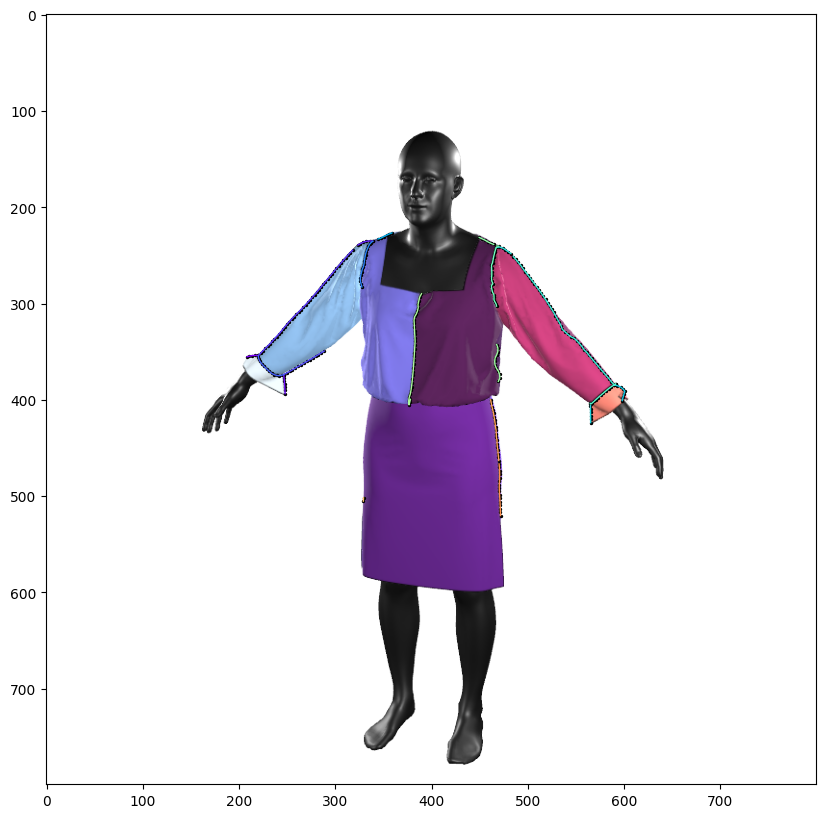

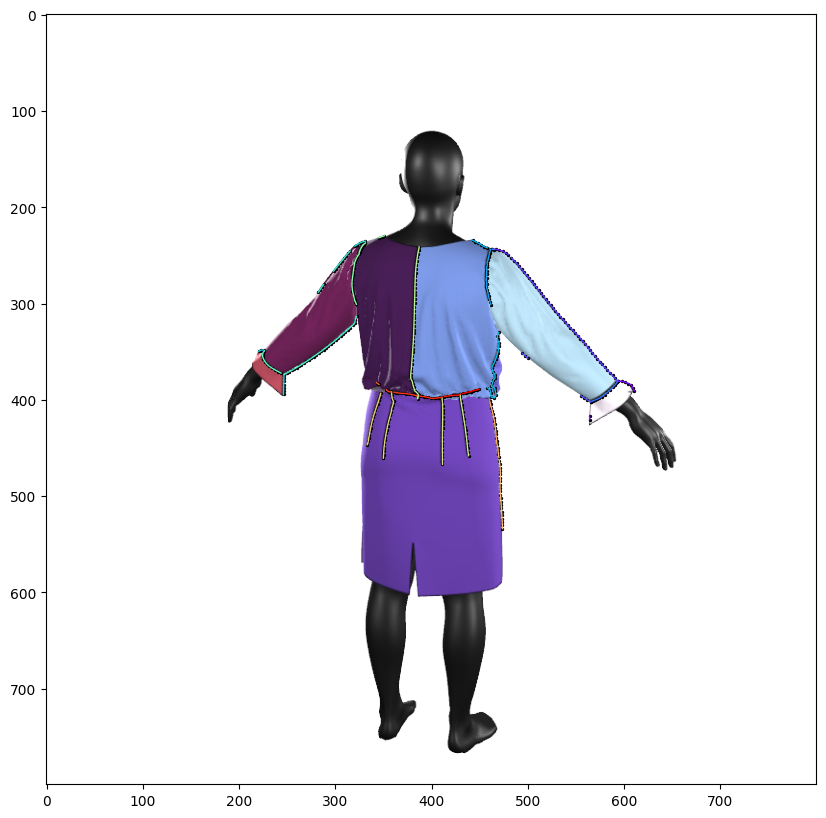

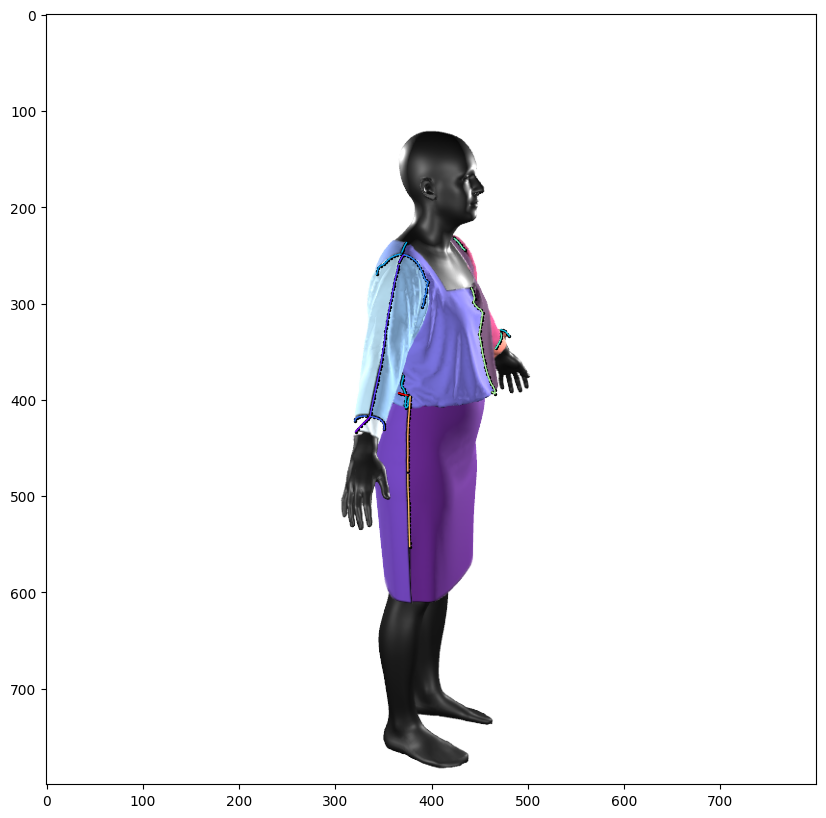

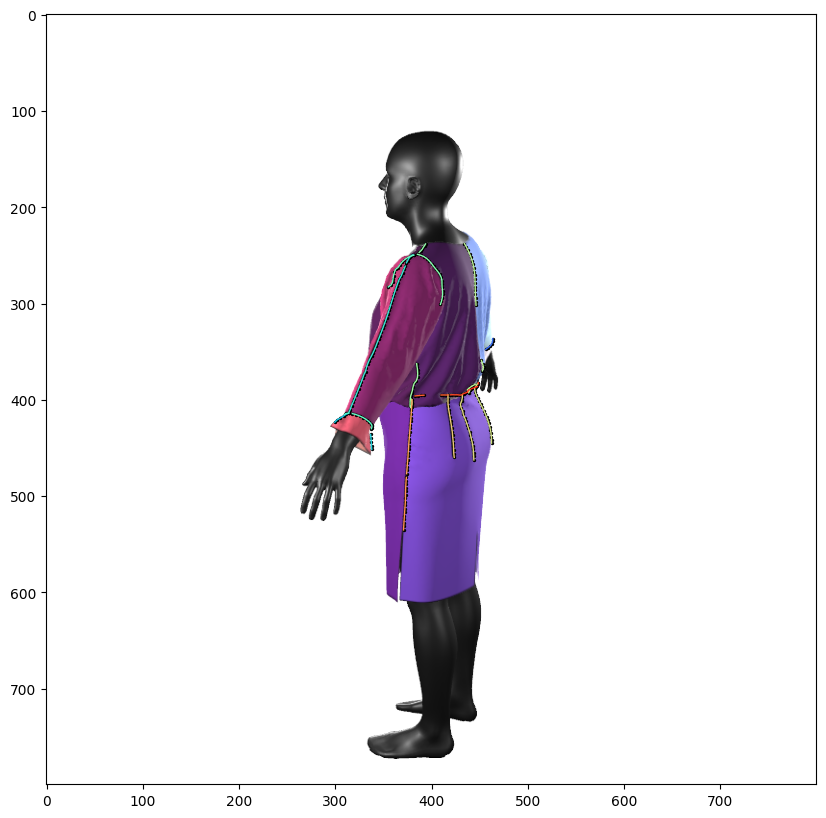

In [464]:
STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side in fltrd_vis_seam_line_dict.keys():
    plt.figure(figsize=(10, 10))
    plt.imshow(rendered_image_dict[side])
    
    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        for segment_idx, segment_idx_list in enumerate(seam_dict["segment_idx_list"]):
            
            x = [fltrd_proj_vert_pos_dict[side][idx][0] for idx in segment_idx_list]
            y = [fltrd_proj_vert_pos_dict[side][idx][1] for idx in segment_idx_list]
            
            # Draw polyline connecting the vertices
            plt.plot(x, y, '-', color=colors[seam_idx], linewidth=1)
            
            # Optionally add points at vertices
            plt.scatter(x, y, color="black", s=2)

    plt.show()

=====================================================================

In [350]:
# Test Code for connect and segment the seam line

import random

MIN_CONSEC_VERT_TO_BE_SEGMENT = 2

# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2

N = 20

data_arr = np.array(list(range(N)))
conn_arr = np.array([random.randint(0, 1) for _ in range(N)])
# ll = np.array(
#     [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
# )
conn_arr_b = conn_arr.copy()



print(
    "idx  :",
    "".join(map(
        lambda x : f"{x:3d}",
        data_arr.tolist()
    ))
)

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)


## If length of disconnection < MIN_CONSEC_VERT_TO_DISCONNECT,
## then connect the disconnection
idx = 0
while idx < len(conn_arr) :
    if idx >= len(conn_arr) - 2 :
        break
    while not (conn_arr[idx] == 1 and conn_arr[idx + 1] == 0) :
        if idx >= len(conn_arr) - 2 :
            break
        idx += 1
    if idx >= len(conn_arr) - 2 :
        break
    window_end_idx = min(
        idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1,
        len(conn_arr) - 1
    )
    # print(idx, window_end_idx, conn_arr[idx:window_end_idx+1].tolist())
    
    for rid in range(window_end_idx, idx, -1) :
        if conn_arr[rid] == 1 :
            conn_arr[idx:rid] = 1
            break
    
    idx = rid
    
    # print(conn_arr.tolist())

# print("Connect Disconnected with MIN_CONSEC_VERT_TO_DISCONNECT = ", MIN_CONSEC_VERT_TO_DISCONNECT)

# print(
#     "",
#     "".join(map(
#         lambda x : f"{x:3d}",
#         conn_arr_b.tolist()
#     ))
# )

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)
conn_arr_b = conn_arr.copy()
## if length of connection < MIN_CONSEC_VERT_TO_BE_SEGMENT,
## then delete the connection
idx = 0
while idx < len(conn_arr) :
    if conn_arr[idx] != 1 :
        idx += 1
        continue
    idx2 = idx+1
    while idx2 < len(conn_arr) and conn_arr[idx2] == 1 :
        idx2 += 1
    if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
        conn_arr[idx:idx2] = 0
    idx = idx2
    
# print("Delete Connection with MIN_CONSEC_VERT_TO_BE_SEGMENT = ", MIN_CONSEC_VERT_TO_BE_SEGMENT)
# print("".join(map(
#     lambda x : f"{x:3d}",
#     conn_arr_b.tolist()
# )))

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)

## make list of line segments
line_segment_list = []
idx = conn_arr.tolist().index(1)
while idx < len(conn_arr) :
    line_segment = []
    while idx < len(conn_arr) and conn_arr[idx] == 1 :
        line_segment.append(idx)
        idx += 1
    if len(line_segment) > 0 :
        line_segment_list.append(line_segment)
    idx += 1
    
print(line_segment_list)

        

In [384]:
fltrd_vis_seam_line_dict[side][stch_idx]["segment_idx_list"]

[[551, 757], [761, 762, 763, 764, 765]]

In [376]:
fltrd_vis_seam_line_dict[side][stch_idx]["segment_idx_list"]

[[551, 757], [761, 762, 763, 764, 765]]

In [374]:
filtered_mesh

<trimesh.Trimesh(vertices.shape=(17196, 3), faces.shape=(34015, 3))>

### Test Code for conect and segment the seam line


In [335]:
import random

MIN_CONSEC_VERT_TO_BE_SEGMENT = 2

# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2

N = 20

data_arr = np.array(list(range(N)))
conn_arr = np.array([random.randint(0, 1) for _ in range(N)])
# ll = np.array(
#     [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
# )
conn_arr_b = conn_arr.copy()



print(
    "idx  :",
    "".join(map(
        lambda x : f"{x:3d}",
        data_arr.tolist()
    ))
)

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)


## If length of disconnection < MIN_CONSEC_VERT_TO_DISCONNECT,
## then connect the disconnection
idx = 0
while idx < len(conn_arr) :
    if idx >= len(conn_arr) - 2 :
        break
    while not (conn_arr[idx] == 1 and conn_arr[idx + 1] == 0) :
        if idx >= len(conn_arr) - 2 :
            break
        idx += 1
    if idx >= len(conn_arr) - 2 :
        break
    window_end_idx = min(
        idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1,
        len(conn_arr) - 1
    )
    # print(idx, window_end_idx, conn_arr[idx:window_end_idx+1].tolist())
    
    for rid in range(window_end_idx, idx, -1) :
        if conn_arr[rid] == 1 :
            conn_arr[idx:rid] = 1
            break
    
    idx = rid
    
    # print(conn_arr.tolist())

# print("Connect Disconnected with MIN_CONSEC_VERT_TO_DISCONNECT = ", MIN_CONSEC_VERT_TO_DISCONNECT)

# print(
#     "",
#     "".join(map(
#         lambda x : f"{x:3d}",
#         conn_arr_b.tolist()
#     ))
# )

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)
conn_arr_b = conn_arr.copy()
## if length of connection < MIN_CONSEC_VERT_TO_BE_SEGMENT,
## then delete the connection
idx = 0
while idx < len(conn_arr) :
    if conn_arr[idx] != 1 :
        idx += 1
        continue
    idx2 = idx+1
    while idx2 < len(conn_arr) and conn_arr[idx2] == 1 :
        idx2 += 1
    if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
        conn_arr[idx:idx2] = 0
    idx = idx2
    
# print("Delete Connection with MIN_CONSEC_VERT_TO_BE_SEGMENT = ", MIN_CONSEC_VERT_TO_BE_SEGMENT)
# print("".join(map(
#     lambda x : f"{x:3d}",
#     conn_arr_b.tolist()
# )))

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)

## make list of line segments
line_segment_list = []
idx = conn_arr.tolist().index(1)
while idx < len(conn_arr) :
    line_segment = []
    while idx < len(conn_arr) and conn_arr[idx] == 1 :
        line_segment.append(idx)
        idx += 1
    if len(line_segment) > 0 :
        line_segment_list.append(line_segment)
    idx += 1
    
print(line_segment_list)


idx  :   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
conn :   0  1  1  1  0  1  1  1  0  1  0  1  1  1  0  0  0  0  0  0
conn :   0  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
conn :   0  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]


In [267]:
import random

MIN_CONSEC_VERT_TO_BE_SEGMENT = 2

# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2

N = 20

data_arr = np.array(list(range(N)))
conn_arr = np.array([random.randint(0, 1) for _ in range(N)])
# ll = np.array(
#     [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
# )
conn_arr_b = conn_arr.copy()



print(
    "idx  :",
    "".join(map(
        lambda x : f"{x:3d}",
        data_arr.tolist()
    ))
)

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)


## If length of disconnection < MIN_CONSEC_VERT_TO_DISCONNECT,
## then connect the disconnection
idx = 0
while idx < len(conn_arr) :
    if idx >= len(conn_arr) - 2 :
        break
    while not (conn_arr[idx] == 1 and conn_arr[idx + 1] == 0) :
        if idx >= len(conn_arr) - 2 :
            break
        idx += 1
    if idx >= len(conn_arr) - 2 :
        break
    window_end_idx = min(
        idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1,
        len(conn_arr) - 1
    )
    # print(idx, window_end_idx, conn_arr[idx:window_end_idx+1].tolist())
    
    for rid in range(window_end_idx, idx, -1) :
        if conn_arr[rid] == 1 :
            conn_arr[idx:rid] = 1
            break
    
    idx = rid
    
    # print(conn_arr.tolist())

# print("Connect Disconnected with MIN_CONSEC_VERT_TO_DISCONNECT = ", MIN_CONSEC_VERT_TO_DISCONNECT)

# print(
#     "",
#     "".join(map(
#         lambda x : f"{x:3d}",
#         conn_arr_b.tolist()
#     ))
# )

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)
conn_arr_b = conn_arr.copy()
## if length of connection < MIN_CONSEC_VERT_TO_BE_SEGMENT,
## then delete the connection
idx = 0
while idx < len(conn_arr) :
    if conn_arr[idx] != 1 :
        idx += 1
        continue
    idx2 = idx+1
    while idx2 < len(conn_arr) and conn_arr[idx2] == 1 :
        idx2 += 1
    if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
        conn_arr[idx:idx2] = 0
    idx = idx2
    
# print("Delete Connection with MIN_CONSEC_VERT_TO_BE_SEGMENT = ", MIN_CONSEC_VERT_TO_BE_SEGMENT)
# print("".join(map(
#     lambda x : f"{x:3d}",
#     conn_arr_b.tolist()
# )))

print(
    "conn :",
    "".join(map(
        lambda x : f"{x:3d}",
        conn_arr.tolist()
    ))
)

## make list of line segments
line_segment_list = []
idx = conn_arr.tolist().index(1)
while idx < len(conn_arr) :
    line_segment = []
    while idx < len(conn_arr) and conn_arr[idx] == 1 :
        line_segment.append(idx)
        idx += 1
    if len(line_segment) > 0 :
        line_segment_list.append(line_segment)
    idx += 1
    
print(line_segment_list)


[1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


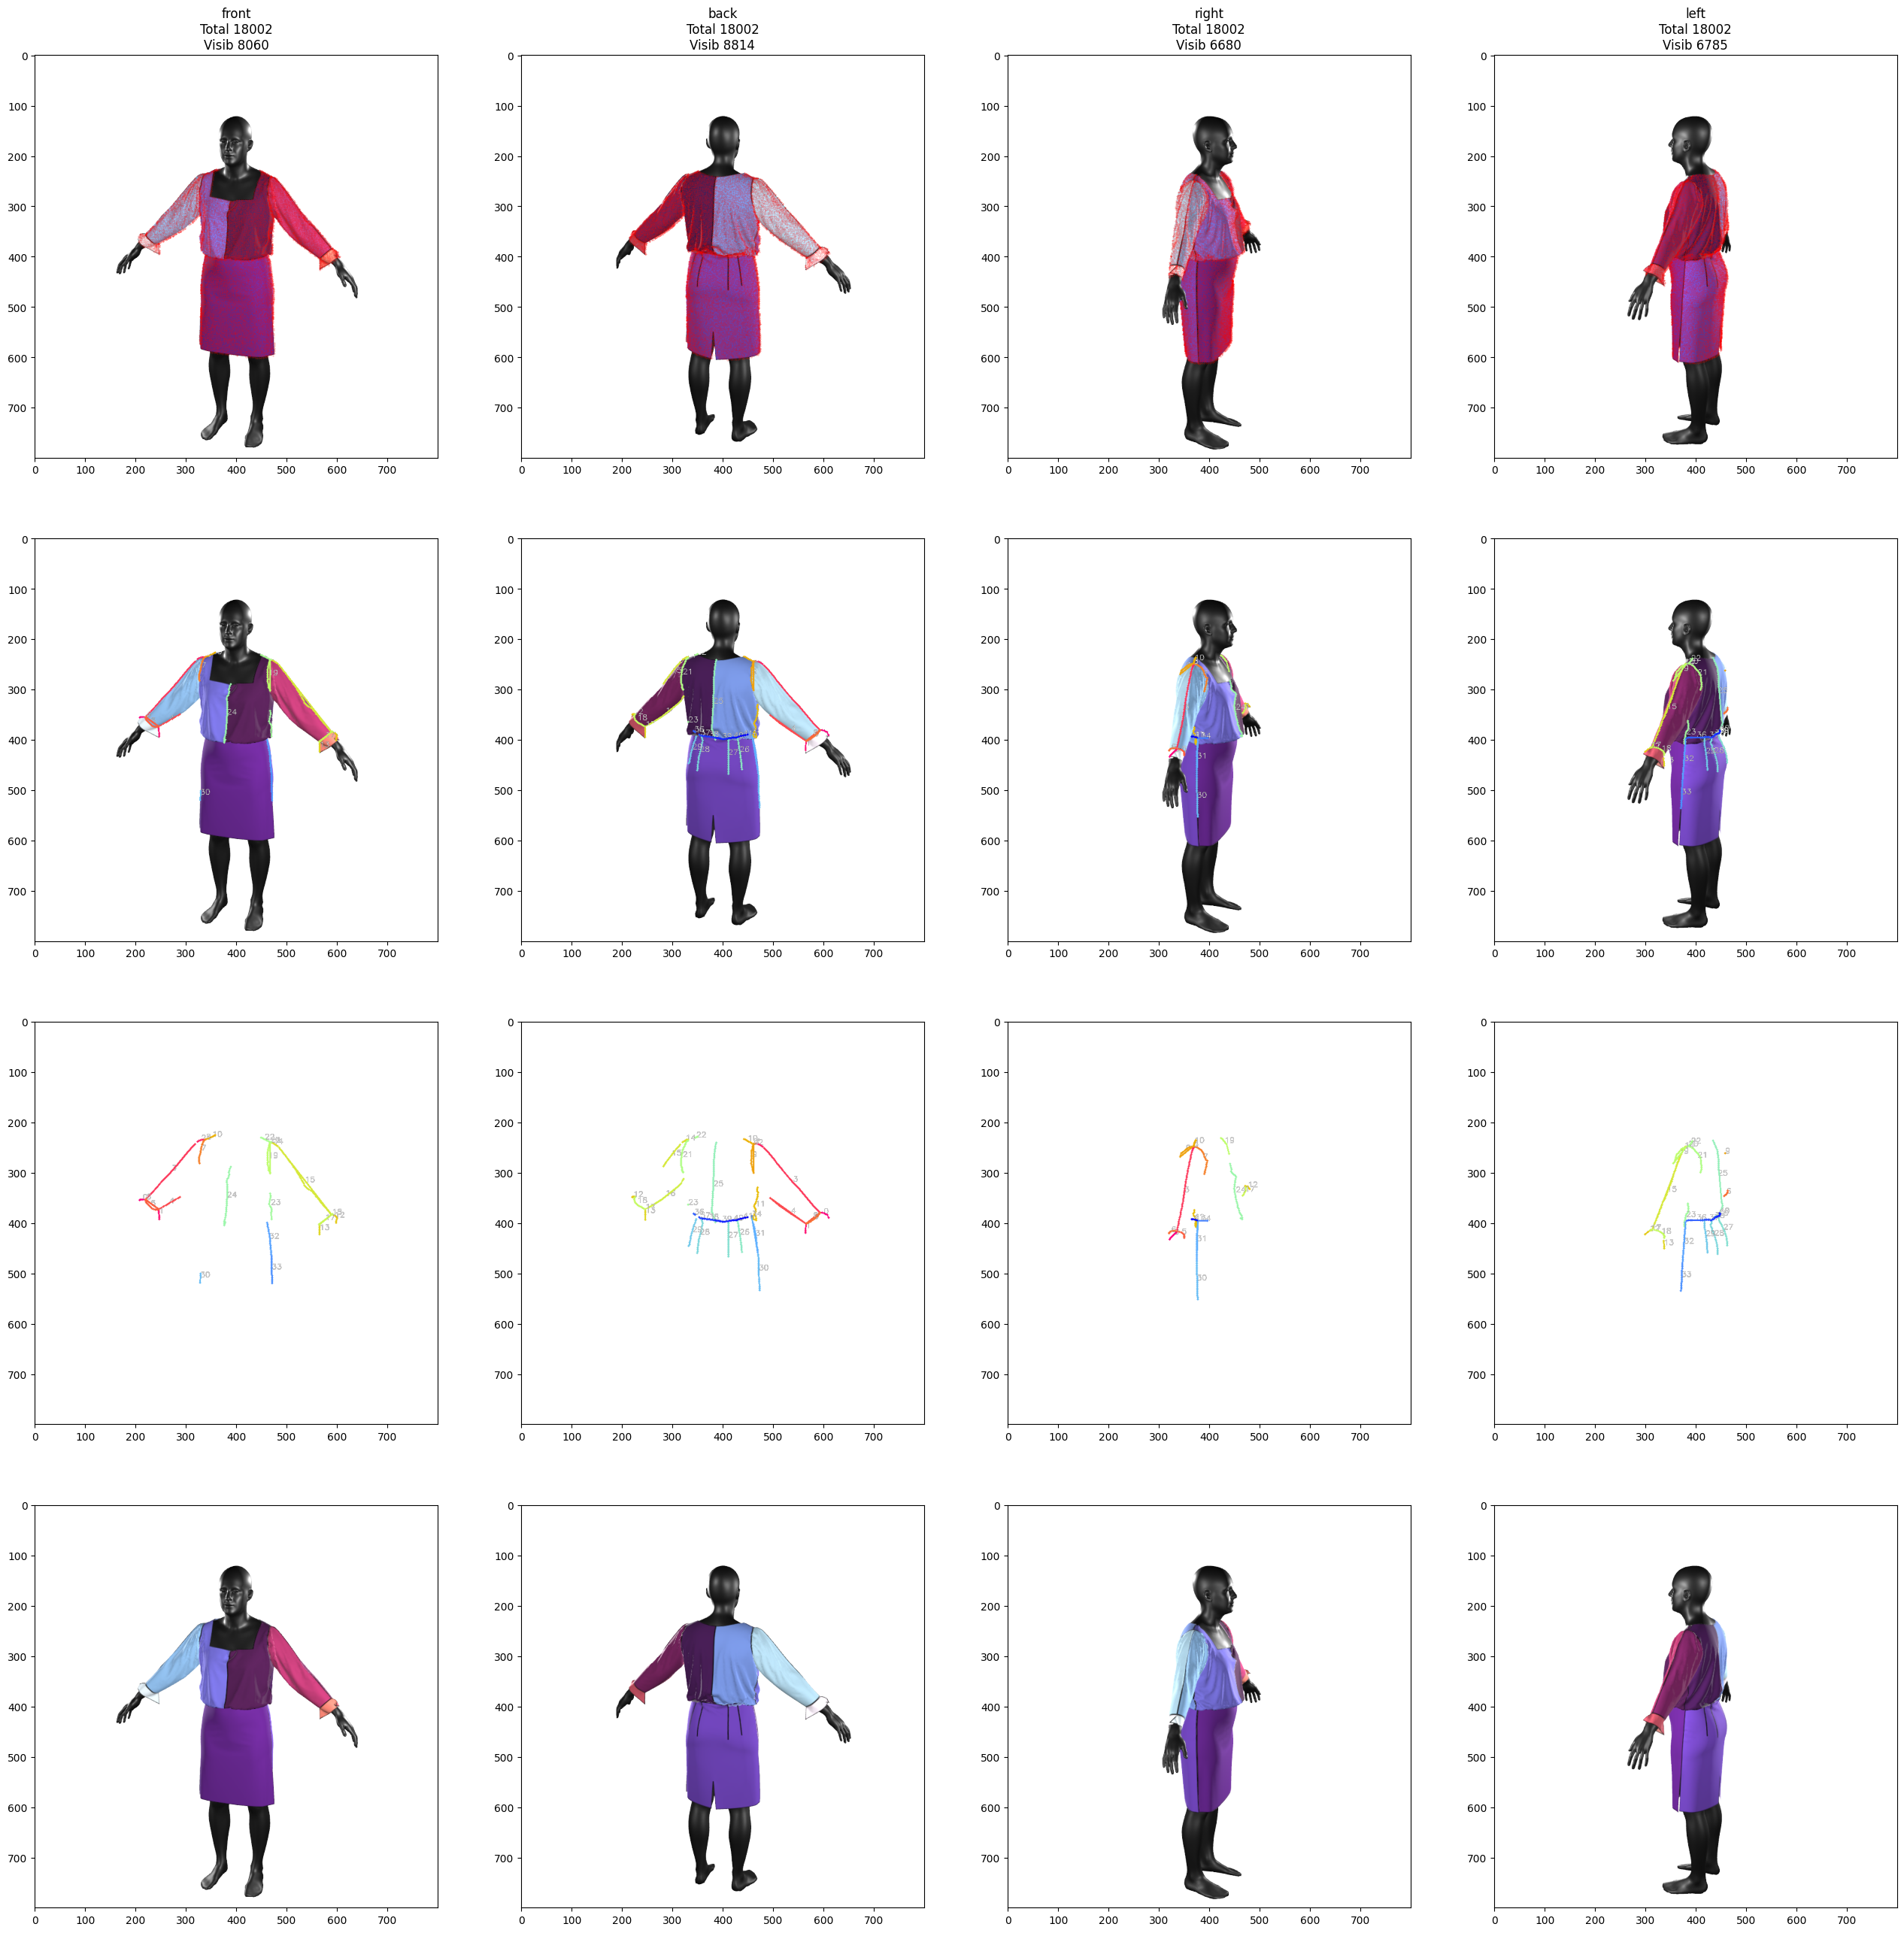

In [21]:


visible_seam_vertex_dict = {
    side : {
        stitch_idx : None
        for stitch_idx in stitch_dict.keys()
    }
    for side in render_props["sides"]
}

for side in render_props["sides"] :    
    visible_vertex_mask = np.array(vertex_visibility_mask_dict[side])
    for stitch_idx, stitch_info in stitch_dict.items():
        
        stitch_vertex_mask = stitch_vertex_mask_dict[stitch_idx]
        
        mask = stitch_vertex_mask & visible_vertex_mask
        
        pixel_coords = np.array(projected_vertex_pose_dict[side])
        px = np.clip(pixel_coords[:, 0].astype(int), 0, render_props["resolution"][0] - 1)
        py = np.clip(pixel_coords[:, 1].astype(int), 0, render_props["resolution"][1] - 1)
        pixel_coords = np.array([px, py]).T

        visible_seam_vertex_dict[side][stitch_idx] = pixel_coords[mask]
        
        
unique_stitch_indices = list(stitch_dict.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stitch_indices)))
color_dict = dict(zip(unique_stitch_indices, colors))
unique_color_list = (colors[:, [2, 1, 0, 3]] * 255).astype(np.uint8) 

vis_image_list = list(map(
    lambda x : np.array(x, dtype=np.uint8),
    rendered_image_dict.values()
))

vis_image_list_2 = list(map(
    lambda x : np.ones_like(x, dtype=np.uint8) * 255,
    vis_image_list
))


for side_idx, side in enumerate(visible_seam_vertex_dict.keys()):
    for stitch_idx, visible_seem_coord in visible_seam_vertex_dict[side].items():
        
        color = unique_color_list[stitch_idx]
        if visible_seem_coord is not None and len(visible_seem_coord) > 0:
            
            cv2.putText(
                vis_image_list[side_idx],
                str(stitch_idx),
                org=visible_seem_coord.mean(axis=0).astype(np.int32),  # Offset text slightly from point
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(0, 0, 0),
                thickness=1
            )
            cv2.putText(
                vis_image_list_2[side_idx],
                str(stitch_idx),
                org=visible_seem_coord.mean(axis=0).astype(np.int32),  # Offset text slightly from point
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(0, 0, 0),
                thickness=1
            )
            
            if len(visible_seem_coord) > 1:
                for point_prev, point_cur in zip(visible_seem_coord[:-1], visible_seem_coord[1:]):
                    cv2.line(
                        vis_image_list[side_idx],
                        point_prev.astype(np.int32).tolist(),
                        point_cur.astype(np.int32).tolist(),
                        color.tolist(),
                        thickness=2
                    )
                    cv2.line(
                        vis_image_list_2[side_idx],
                        point_prev.astype(np.int32).tolist(),
                        point_cur.astype(np.int32).tolist(),
                        color.tolist(),
                        thickness=2
                    )
            for point in visible_seem_coord:
                cv2.circle(
                    vis_image_list[side_idx],
                    center=point.astype(np.int32).tolist(),
                    radius=2,
                    color=color.tolist(),
                    thickness=-1
                )
                cv2.circle(
                    vis_image_list_2[side_idx],
                    center=point.astype(np.int32).tolist(),
                    radius=2,
                    color=color.tolist(),
                    thickness=-1
                )
                

# Visualization
FIG_LEN = 8
NCOLS = len(render_props["sides"])
NROWS = 4
plt.figure(figsize=(FIG_LEN * NCOLS, FIG_LEN * NROWS))
for i, (side, image, coords, vis) in enumerate(zip(
    render_props["sides"],
    rendered_image_dict.values(),
    projected_vertex_pose_dict.values(),
    vertex_visibility_mask_dict.values()
)):
    coords = np.array(coords)
    vis = np.array(vis)
    plt.subplot(NROWS, NCOLS, i + 1)
    plt.title(
        f"{render_props['sides'][i]}\nTotal {len(vis)}\nVisib {vis.sum()}"
    )
    plt.imshow(image)
    plt.scatter(coords[vis, 0], coords[vis, 1], c='red', s=0.1, alpha=0.5)
    
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS)
    plt.imshow(vis_image_list[i])
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS * 2)
    plt.imshow(vis_image_list_2[i])
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS * 3)
    plt.imshow(rendered_image_dict[side])
    
# plt.savefig(os.path.join("ANALYSIS", f"{garment_id}_visible_seam_annotation.png"))
plt.show()